In [65]:
import os

if not os.path.exists(p := "./data/unpacked_data"):
    import shutil

    shutil.unpack_archive("./data/facial-keypoints-detection.zip", extract_dir=p)
    shutil.unpack_archive(f"{p}/training.zip", extract_dir=p)
    shutil.unpack_archive(f"{p}/test.zip", extract_dir=p)
    for file_name in os.listdir(p):
        if file_name.endswith(".zip"):
            os.remove(os.path.join(p, file_name))

In [66]:
import pandas as pd

train_df = pd.read_csv("./data/unpacked_data/training.csv")
train_df.head(2)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...


In [67]:
print(train_df.shape)  # (7049, 31)
train_df.dropna(inplace=True)
train_df.shape  # (2140, 31)

(7049, 31)


(2140, 31)

In [68]:
import numpy as np

# left_eye_center_x,            left_eye_center_y,          right_eye_center_x,
# right_eye_center_y,           left_eye_inner_corner_x,    left_eye_inner_corner_y,
# left_eye_outer_corner_x,      left_eye_outer_corner_y,    right_eye_inner_corner_x,
# right_eye_inner_corner_y,     right_eye_outer_corner_x,   right_eye_outer_corner_y,
# left_eyebrow_inner_end_x,     left_eyebrow_inner_end_y,   left_eyebrow_outer_end_x,
# left_eyebrow_outer_end_y,     right_eyebrow_inner_end_x,  right_eyebrow_inner_end_y,
# right_eyebrow_outer_end_x,    right_eyebrow_outer_end_y,  nose_tip_x,nose_tip_y,
# mouth_left_corner_x,          mouth_left_corner_y,        mouth_right_corner_x,
# mouth_right_corner_y,         mouth_center_top_lip_x,     mouth_center_top_lip_y,
# mouth_center_bottom_lip_x,    mouth_center_bottom_lip_y
y = train_df.iloc[:, :-1].values

# Image (96*96) grayscale (0,255)
X = (
    np.vectorize(int)(np.array([img.split() for img in train_df.iloc[:, -1].values]))
    / 255
)
print(f"y shape:{y.shape}\nX shape:{X.shape}")

y shape:(2140, 30)
X shape:(2140, 9216)


In [69]:
X

array([[0.93333333, 0.9254902 , 0.92941176, ..., 0.2745098 , 0.29411765,
        0.35294118],
       [0.85882353, 0.84313725, 0.8       , ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.56470588, 0.55686275, 0.62352941, ..., 0.30588235, 0.30588235,
        0.30196078],
       ...,
       [0.12156863, 0.15686275, 0.18431373, ..., 0.15294118, 0.2       ,
        0.29411765],
       [0.02745098, 0.00392157, 0.01960784, ..., 0.70196078, 0.69411765,
        0.22352941],
       [0.26666667, 0.0745098 , 0.0745098 , ..., 0.49019608, 0.48627451,
        0.46666667]])

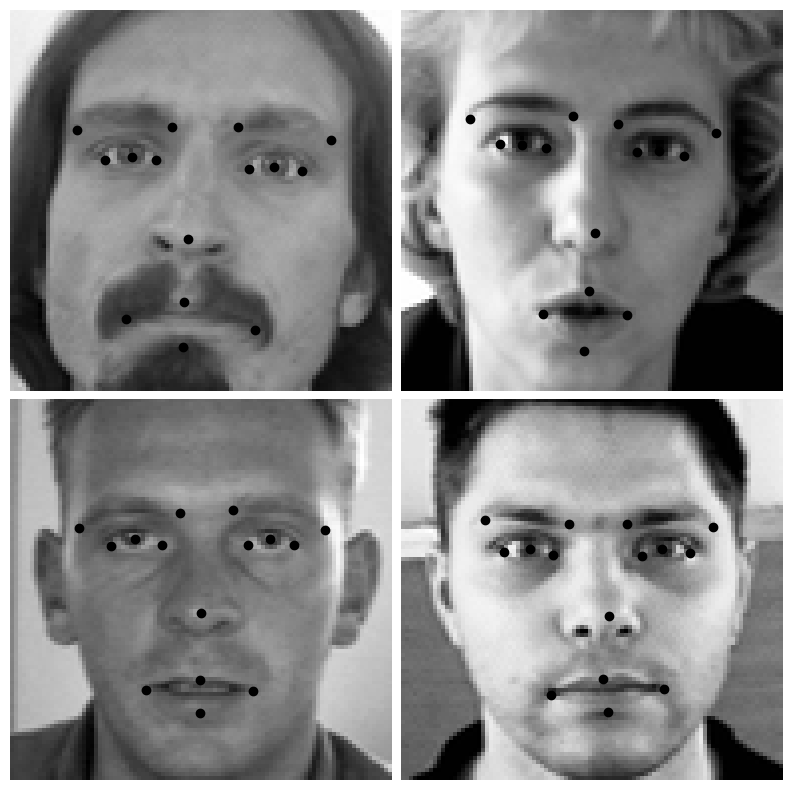

In [70]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(96, 96), cmap="gray")
    key_points = y[i].reshape(-1, 2)
    ax.scatter(key_points[:, 0], key_points[:, 1], c="black")
    ax.axis("off")
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.show()

In [71]:
import tensorflow as tf

input_shape = (96, 96, 1)
output_shape = 30

input_layer = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu")(input_layer)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
output_layer = tf.keras.layers.Dense(output_shape)(x)


model = tf.keras.Model(input_layer, output_layer)

In [72]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"],
)

In [73]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 20, 20, 64)        3692

In [74]:
model.fit(X.reshape(-1, 96, 96, 1), y, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20


54/54 [==============================] - 1s 13ms/step - loss: 423.6216 - mae: 13.7555 - val_loss: 32.7551 - val_mae: 4.2226
Epoch 2/20
54/54 [==============================] - 1s 10ms/step - loss: 14.0634 - mae: 2.7843 - val_loss: 20.1287 - val_mae: 3.3861
Epoch 3/20
54/54 [==============================] - 1s 9ms/step - loss: 10.4001 - mae: 2.3701 - val_loss: 18.8410 - val_mae: 3.2645
Epoch 4/20
54/54 [==============================] - 0s 9ms/step - loss: 9.4705 - mae: 2.2596 - val_loss: 16.9965 - val_mae: 3.0879
Epoch 5/20
54/54 [==============================] - 1s 10ms/step - loss: 9.0139 - mae: 2.2014 - val_loss: 15.6334 - val_mae: 2.9601
Epoch 6/20
54/54 [==============================] - 0s 9ms/step - loss: 7.3208 - mae: 1.9808 - val_loss: 13.6249 - val_mae: 2.7448
Epoch 7/20
54/54 [==============================] - 1s 10ms/step - loss: 5.6812 - mae: 1.7327 - val_loss: 12.4353 - val_mae: 2.6403
Epoch 8/20
54/54 [==============================] - 1s 10ms/step - loss: 4.8069 - mae

In [75]:
y_pred = model.predict(X.reshape(-1, 96, 96, 1))

67/67 [==============================] - 0s 3ms/step


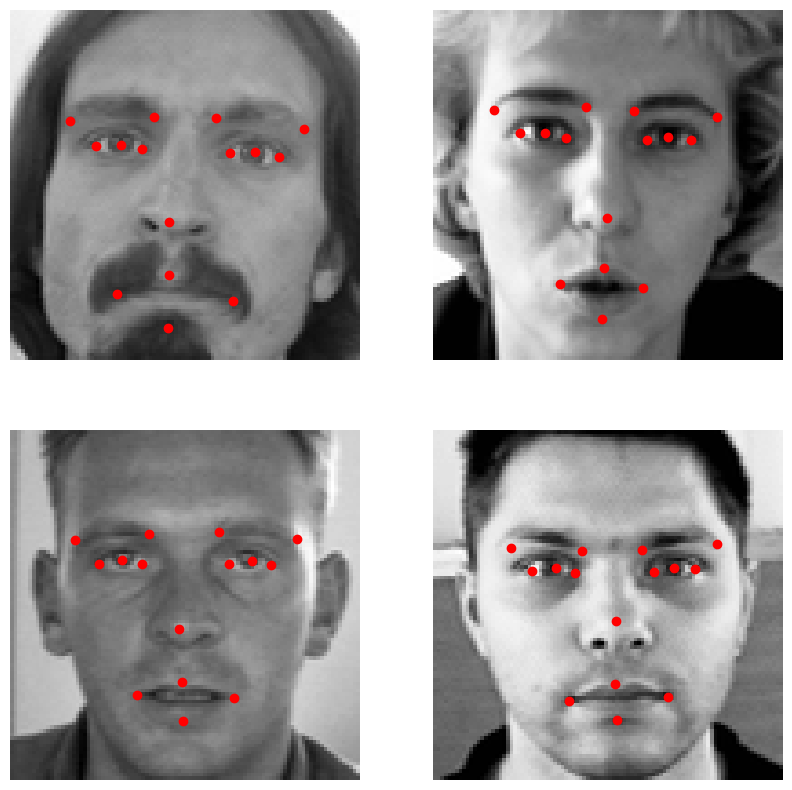

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(96, 96), cmap="gray")
    key_points = y_pred[i].reshape(-1, 2)
    ax.scatter(key_points[:, 0], key_points[:, 1], c="red")
    ax.axis("off")